In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 80

ng =7

ng_adju = (/ 2 /) 

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 10 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

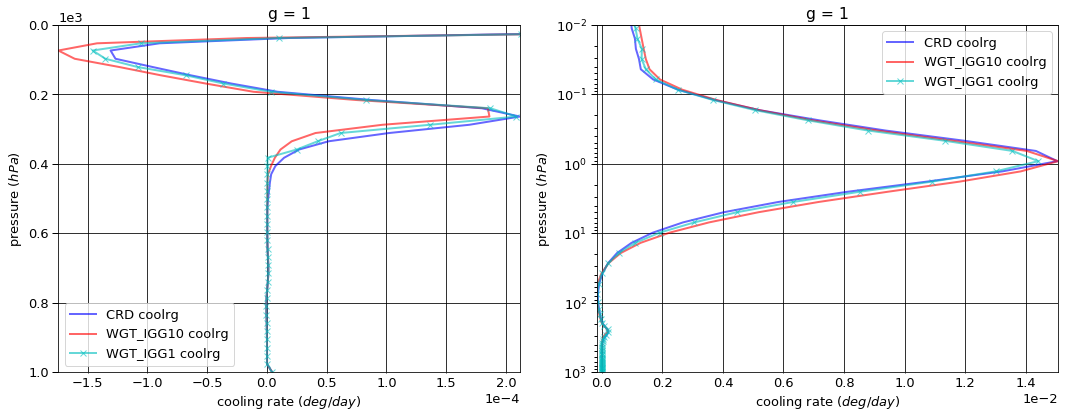

# Figure: cooling rate g-group 2

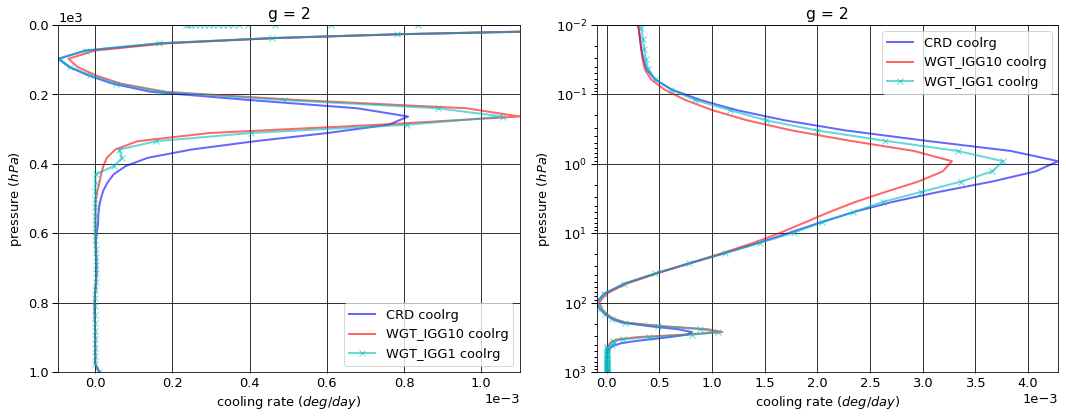

# Figure: cooling rate g-group 3

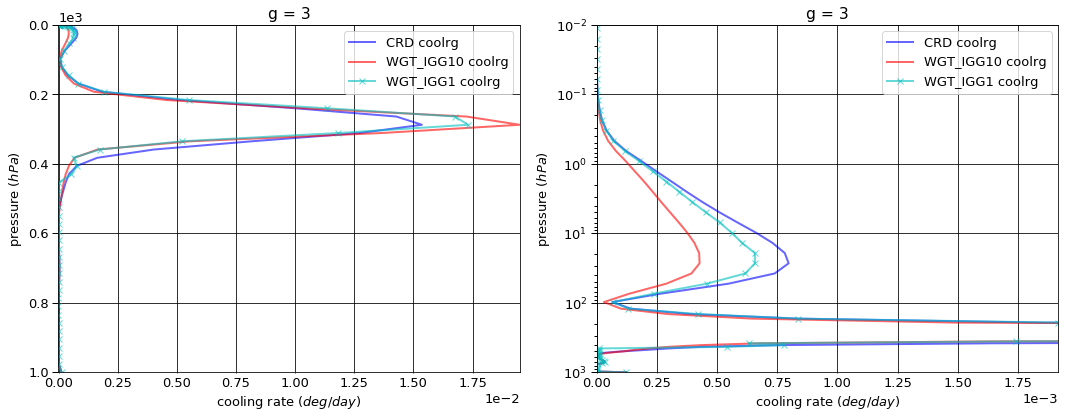

# Figure: cooling rate g-group 4

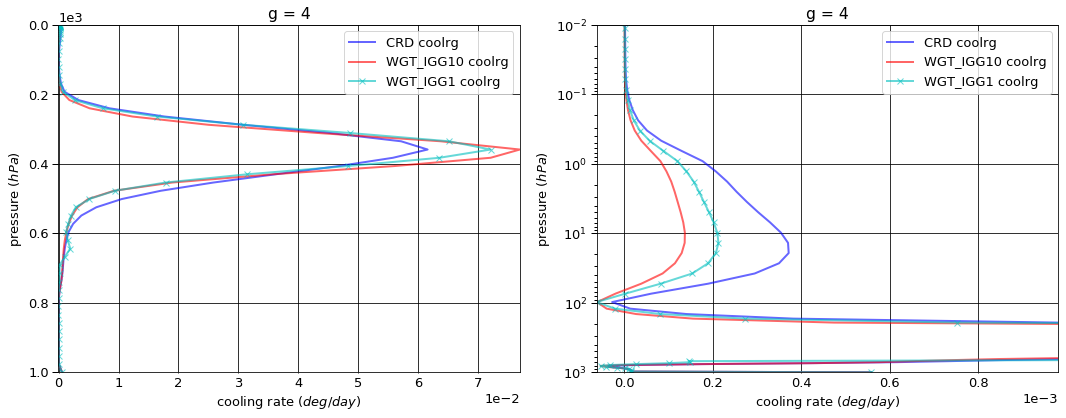

# Figure: cooling rate g-group 5

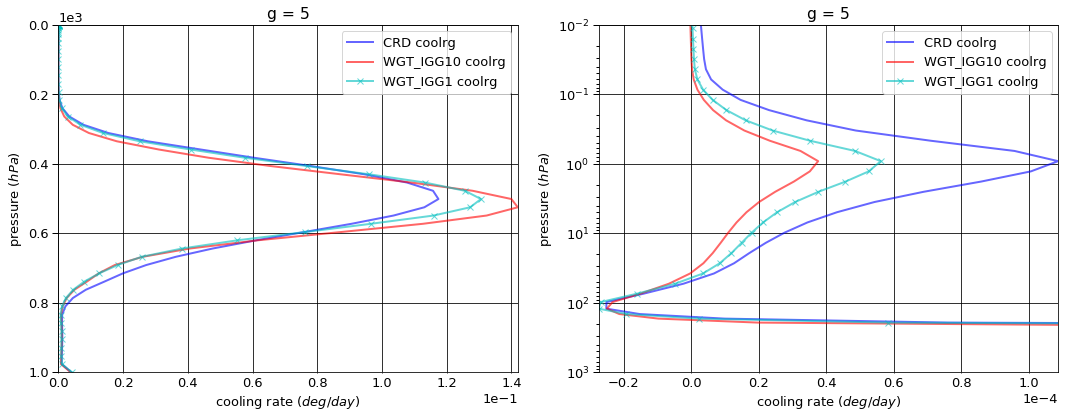

# Figure: cooling rate g-group 6

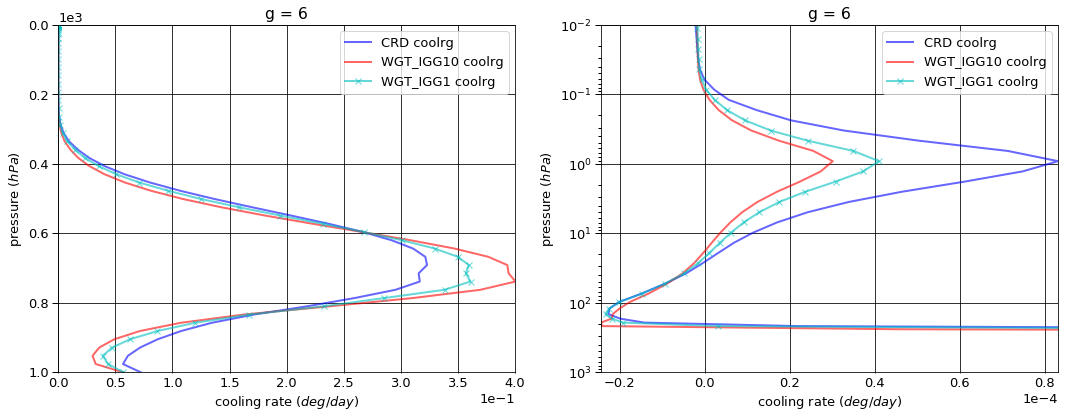

# Figure: cooling rate g-group 7

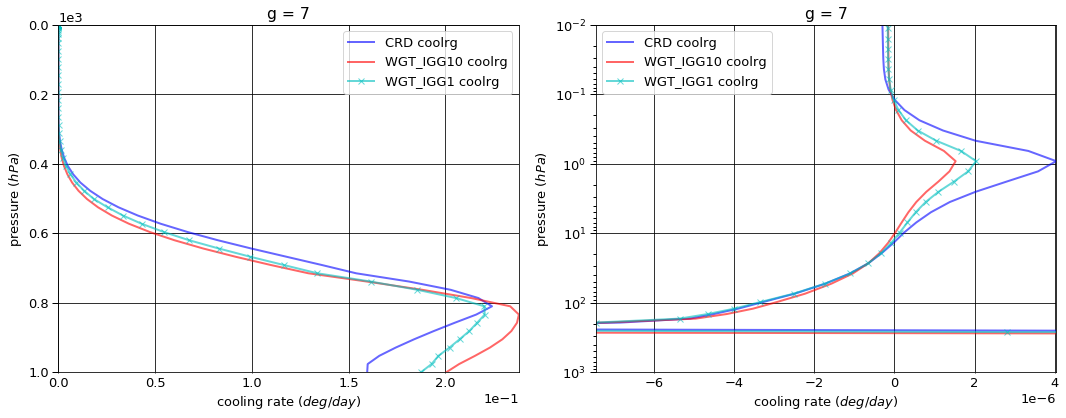

# Figure: cooling rate g-group total

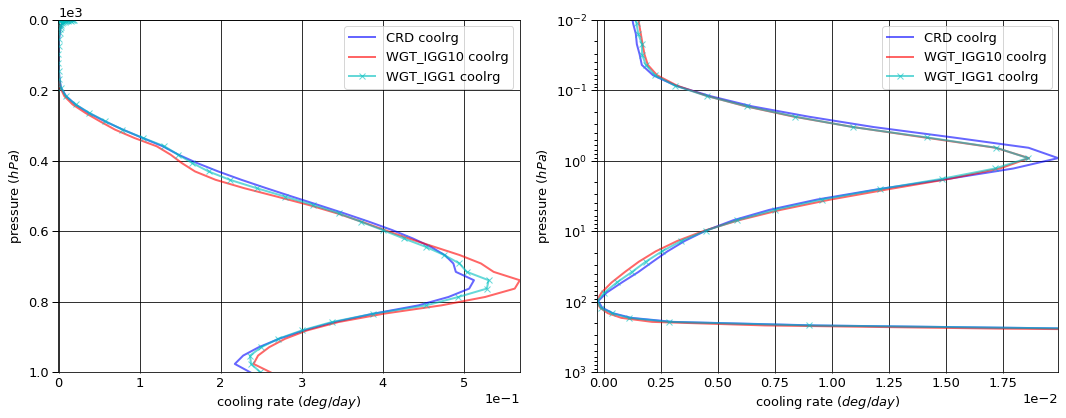

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008867   0.000000  -0.008867
  1013.0   76     -0.018762   0.018749  -0.000013
2 0.0      1      -0.018898   0.000000  -0.018898
  1013.0   76     -0.046660   0.046629  -0.000031
3 0.0      1      -0.221845   0.000000  -0.221845
  1013.0   76     -0.514793   0.514449  -0.000344
4 0.0      1      -1.237156   0.000000  -1.237156
  1013.0   76     -2.329209   2.327653  -0.001555
5 0.0      1      -3.643870   0.000000  -3.643870
  1013.0   76     -5.552857   5.542531  -0.010326
6 0.0      1     -13.811697   0.000000 -13.811697
  1013.0   76    -17.514974  17.155259  -0.359715
7 0.0      1     -11.047946   0.000000 -11.047946
  1013.0   76    -12.514479  10.295756  -2.218723


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008930   0.000000  -0.008930
  1013.0   76     -0.018762   0.018749  -0.000013
2 0.0      1      -0.017742   0.000000  -0.017742
  1013.0   76     -0.046660   0.046629  -0.000031
3 0.0      1      -0.221087   0.000000  -0.221087
  1013.0   76     -0.514793   0.514449  -0.000344
4 0.0      1      -1.239652   0.000000  -1.239652
  1013.0   76     -2.329209   2.327653  -0.001555
5 0.0      1      -3.676306   0.000000  -3.676306
  1013.0   76     -5.552857   5.543236  -0.009622
6 0.0      1     -13.875693   0.000000 -13.875693
  1013.0   76    -17.514974  17.305096  -0.209878
7 0.0      1     -11.198519   0.000000 -11.198519
  1013.0   76    -12.514479  10.383313  -2.131166


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008799   0.000000  -0.008799
  1013.0   76     -0.018762   0.018749  -0.000013
2 0.0      1      -0.018089   0.000000  -0.018089
  1013.0   76     -0.046660   0.046629  -0.000031
3 0.0      1      -0.217136   0.000000  -0.217136
  1013.0   76     -0.514793   0.514449  -0.000344
4 0.0      1      -1.222380   0.000000  -1.222380
  1013.0   76     -2.329209   2.327653  -0.001555
5 0.0      1      -3.623897   0.000000  -3.623897
  1013.0   76     -5.552857   5.543204  -0.009653
6 0.0      1     -13.801141   0.000000 -13.801141
  1013.0   76    -17.514974  17.292940  -0.222034
7 0.0      1     -11.161040   0.000000 -11.161040
  1013.0   76    -12.514479  10.141595  -2.372884


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -6.372450e-05  0.000000 -6.372450e-05
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      1.155445e-03  0.000000  1.155445e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
3 0.0      1      7.578500e-04  0.000000  7.578500e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1     -2.495900e-03  0.000000 -2.495900e-03
  1013.0   76     0.000000e+00  0.000000 -2.168404e-19
5 0.0      1     -3.243600e-02  0.000000 -3.243600e-02
  1013.0   76     8.881784e-16  0.000704  7.043924e-04
6 0.0      1     -6.399600e-02  0.000000 -6.399600e-02
  1013.0   76     0.000000e+00  0.149837  1.498369e-01
7 0.0      1     -1.505730e-01  0.000000 -1.505730e-01
  1013.0   76     0.000000e+00  0.087557  8.755670e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      6.716330e-05  0.000000  6.716330e-05
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      8.084220e-04  0.000000  8.084220e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
3 0.0      1      4.708850e-03  0.000000  4.708850e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1      1.477620e-02  0.000000  1.477620e-02
  1013.0   76     0.000000e+00  0.000000 -2.168404e-19
5 0.0      1      1.997300e-02  0.000000  1.997300e-02
  1013.0   76     8.881784e-16  0.000673  6.728875e-04
6 0.0      1      1.055600e-02  0.000000  1.055600e-02
  1013.0   76     0.000000e+00  0.137681  1.376812e-01
7 0.0      1     -1.130940e-01  0.000000 -1.130940e-01
  1013.0   76     0.000000e+00 -0.154161 -1.541613e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      4.843709e-04
  1001.112500 75     4.498864e-06
2 0.000312    1      1.855794e-04
  1001.112500 75     1.117754e-05
3 0.000312    1      7.082558e-09
  1001.112500 75     1.234260e-04
4 0.000312    1      9.441920e-07
  1001.112500 75     5.581700e-04
5 0.000312    1      1.045292e-06
  1001.112500 75     4.010363e-03
6 0.000312    1     -3.313481e-06
  1001.112500 75     7.224228e-02
7 0.000312    1     -3.371649e-07
  1001.112500 75     1.596030e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      7.581211e-04
  1001.112500 75     4.498864e-06
2 0.000312    1      2.207425e-04
  1001.112500 75     1.117754e-05
3 0.000312    1      4.208107e-09
  1001.112500 75     1.234260e-04
4 0.000312    1      2.485327e-07
  1001.112500 75     5.581700e-04
5 0.000312    1     -7.642468e-07
  1001.112500 75     3.779458e-03
6 0.000312    1     -2.188197e-06
  1001.112500 75     5.673854e-02
7 0.000312    1     -1.679220e-07
  1001.112500 75     2.004355e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      6.181847e-04
  1001.112500 75     4.498864e-06
2 0.000312    1      2.341389e-04
  1001.112500 75     1.117754e-05
3 0.000312    1      7.103572e-09
  1001.112500 75     1.234260e-04
4 0.000312    1      5.427204e-07
  1001.112500 75     5.581700e-04
5 0.000312    1     -4.971615e-07
  1001.112500 75     4.112295e-03
6 0.000312    1     -2.290555e-06
  1001.112500 75     5.698226e-02
7 0.000312    1     -1.848535e-07
  1001.112500 75     1.873435e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.737502e-04
  1001.112500 75     8.470329e-22
2 0.000312    1      3.516308e-05
  1001.112500 75     0.000000e+00
3 0.000312    1     -2.874451e-09
  1001.112500 75     0.000000e+00
4 0.000312    1     -6.956592e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -1.809538e-06
  1001.112500 75    -2.309048e-04
6 0.000312    1      1.125284e-06
  1001.112500 75    -1.550374e-02
7 0.000312    1      1.692429e-07
  1001.112500 75     4.083243e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.338138e-04
  1001.112500 75     8.470329e-22
2 0.000312    1      4.855950e-05
  1001.112500 75     0.000000e+00
3 0.000312    1      2.101420e-11
  1001.112500 75     0.000000e+00
4 0.000312    1     -4.014715e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -1.542453e-06
  1001.112500 75     1.019322e-04
6 0.000312    1      1.022926e-06
  1001.112500 75    -1.526002e-02
7 0.000312    1      1.523114e-07
  1001.112500 75     2.774044e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.990278,0.000000,-29.990278
1013.0,76,-38.491734,35.901027,-2.590707



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.237929,0.000000,-30.237929
1013.0,76,-38.491734,36.139125,-2.352609



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.052482,0.00000,-30.052482
1013.0,76,-38.491734,35.88522,-2.606515



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.247651,0.000000,-0.247651
1013.0,76,0.000000,0.238098,0.238098



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.062204,0.000000,-0.062204
1013.0,76,0.000000,-0.015807,-0.015807


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000668
1001.112500,75,0.236553



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000976
1001.112500,75,0.261651



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000850
1001.112500,75,0.249135



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000308
1001.112500,75,0.025098



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000182
1001.112500,75,0.012582


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000487,0.000490
2,0.001213,0.001218
3,0.013375,0.013435
4,0.060525,0.060808
5,0.144325,0.145143
6,0.455137,0.456604
7,0.324937,0.322302


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.541951e-19
2,2.122874e-20
3,4.182942e-21
4,5.437189e-22
5,7.067520e-23
6,9.186702e-24
7,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.541951e-19,NaN,0.000487,0.000490,0.000487,0.000490,10.0
2,2.122874e-20,0.137674,0.001213,0.001218,0.001700,0.001708,10.0
3,4.182942e-21,0.197041,0.013375,0.013435,0.015075,0.015143,600.0
4,5.437189e-22,0.129985,0.060525,0.060808,0.075600,0.075951,600.0
5,7.067520e-23,0.129985,0.144325,0.145143,0.219925,0.221094,600.0
6,9.186702e-24,0.129985,0.455137,0.456604,0.675063,0.677698,600.0
7,1.194132e-24,0.129985,0.324937,0.322302,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
